-------------------------------
## 노트북 가이드
- 이 노트북은 CPU에서 사전학습 백본으로 임베딩만 추출(Feature Extraction)하여 간단 분류기를 학습/평가합니다.
- 지원 백본: MobileNetV3 Small, EfficientNet-B0 (timm+HF Hub)
- 모델별 권장 전처리(config)를 자동으로 불러와 일관성을 유지합니다.
-------------------------------


In [21]:
# 유틸리티: 시드 고정, 백본/전처리 로더, 가중치 동결
import os, random
import numpy as np
import torch, timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


def load_backbone_and_transform(repo_id: str):
    """HF Hub repo_id로 timm 모델을 로드하고 해당 전처리 transform/config를 반환."""
    model = timm.create_model(f'hf_hub:{repo_id}', pretrained=True, num_classes=0)
    cfg = resolve_data_config({}, model=model)
    transform = create_transform(**cfg)
    return model, cfg, transform


def freeze_module(module: torch.nn.Module):
    for p in module.parameters():
        p.requires_grad = False
    return module



In [22]:
# 백본 선택과 전처리 일원화 설정
set_seed(42)

REPOS = {
    'mobilenet': 'timm/mobilenetv3_small_100.lamb_in1k',
    'efficient': 'timm/efficientnet_b0.ra_in1k',
}

BACKBONE = 'mobilenet'  # 'efficient' 로 바꾸면 EfficientNet-B0 사용

backbone_model, backbone_cfg, backbone_transform = load_backbone_and_transform(REPOS[BACKBONE])
IMG_SIZE = backbone_cfg['input_size'][-1]
print(f"Using backbone: {BACKBONE} | input size: {IMG_SIZE}")

# feature extraction만 할 경우 동결(필요 시 주석 해제)
# backbone_model = freeze_module(backbone_model)



Using backbone: mobilenet | input size: 224


In [23]:
# 기존 코드와 호환: transform 별칭 제공
transform = backbone_transform  # 아래 Dataset/DataLoader 코드가 그대로 동작



In [24]:
# DataLoader 헬퍼: numpy 배열 + transform 로더 생성
from torch.utils.data import DataLoader
from PIL import Image

class NumpyCIFARDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]


def make_loaders(tr_imgs, tr_lbls, va_imgs, va_lbls, te_imgs, te_lbls, transform, batch_size=16, num_workers=0):
    train_ds = NumpyCIFARDataset(tr_imgs, tr_lbls, transform=transform)
    val_ds   = NumpyCIFARDataset(va_imgs, va_lbls, transform=transform)
    test_ds  = NumpyCIFARDataset(te_imgs, te_lbls, transform=transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader, test_loader



In [25]:
# 임베딩 사전추출 + 간결 학습/평가 루프
import torch.nn as nn
from tqdm import tqdm

@torch.no_grad()
def extract_embeddings(model, loader, device='cpu'):
    model.eval()
    feats, labels = [], []
    for x, y in tqdm(loader, desc='Extract', leave=False):
        x = x.to(device)
        z = model(x)  # timm: num_classes=0 이면 임베딩 반환
        feats.append(z.cpu())
        labels.append(torch.tensor(y))
    feats = torch.cat(feats)
    labels = torch.cat(labels)
    return feats, labels

class LinearClassifier(nn.Module):
    def __init__(self, in_dim: int, num_classes: int):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)
    def forward(self, x):
        return self.fc(x)


def train_simple_linear(train_feats, train_labels, val_feats, val_labels, num_classes, epochs=10, lr=1e-2):
    in_dim = train_feats.shape[1]
    clf = LinearClassifier(in_dim, num_classes)
    opt = torch.optim.AdamW(clf.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()

    for ep in range(1, epochs+1):
        clf.train()
        opt.zero_grad(set_to_none=True)
        logits = clf(train_feats)
        loss = ce(logits, train_labels)
        loss.backward()
        opt.step()

        clf.eval()
        with torch.no_grad():
            val_logits = clf(val_feats)
            val_acc = (val_logits.argmax(1) == val_labels).float().mean().item()
        print(f"[Ep {ep:02d}] loss={loss.item():.4f} | val_acc={val_acc*100:.2f}%")
    return clf


def evaluate(clf, test_feats, test_labels):
    clf.eval()
    with torch.no_grad():
        logits = clf(test_feats)
        acc = (logits.argmax(1) == test_labels).float().mean().item()
    print(f"Test Acc: {acc*100:.2f}%")
    return acc



-------------------------------
## 실행 플로우
1) 백본/전처리 설정 → 2) 데이터 준비/로더 → 3) 임베딩 추출 → 4) 선형 분류기 학습/평가
- end-to-end 미세조정은 제외(간결/가벼움)
-------------------------------


# 🚀 가벼운 전이학습: MobileNet/EfficientNet (timm + HF Hub)

- **목표**: CPU에서 빠르게 돌릴 수 있는 Feature Extraction 파이프라인
- **백본**: MobileNetV3-Small, EfficientNet-B0 (HF Hub 가중치 자동 로드)
- **흐름**: 이미지 → 백본(고정) → 임베딩 → 선형 분류기 학습/평가
- end-to-end 미세조정은 본 노트북 범위 밖(간결/가벼움 유지)


In [26]:
import torch
import sys
print(torch.__version__)
print(sys.version)

2.2.2
3.12.9 (main, Feb  4 2025, 14:38:38) [Clang 16.0.0 (clang-1600.0.26.6)]


## 0. 환경 설정

In [ ]:
# (정리됨) 공용 import/시드/장치 설정은 상단 유틸 셀에서 처리되었습니다.

Device: cpu


## 1. 데이터 준비 (가벼운 설정 적용)

- **Subset**: 10% (CPU에서도 빠르게)
- **Batch size**: 16
- **Epochs**: 2 (데모용)


In [27]:
# 임베딩 추출 → 선형 분류기 학습/평가 실행 예시
NUM_CLASSES = 10

# 1) 임베딩 사전추출
train_feats, train_labels = extract_embeddings(backbone_model, train_loader)
val_feats,   val_labels   = extract_embeddings(backbone_model, val_loader)
test_feats,  test_labels  = extract_embeddings(backbone_model, test_loader)

# 2) 선형 분류기 학습
clf = train_simple_linear(train_feats, train_labels, val_feats, val_labels, num_classes=NUM_CLASSES, epochs=8, lr=1e-2)

# 3) 평가
_ = evaluate(clf, test_feats, test_labels)


Extract:   0%|          | 0/250 [00:00<?, ?it/s]/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_9575/2557685214.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(y))


KeyboardInterrupt: 

In [ ]:
# 데이터 준비: CIFAR-10 → numpy → subset → train/val split → loaders
from torchvision import datasets as tvdatasets
from sklearn.model_selection import train_test_split

root='./data'
train_full = tvdatasets.CIFAR10(root=root, train=True, download=True)
test_set   = tvdatasets.CIFAR10(root=root, train=False, download=True)
class_names = train_full.classes

# torchvision → numpy 변환
images_train, labels_train = zip(*[(np.array(img), lab) for img, lab in train_full])
images_test,  labels_test  = zip(*[(np.array(img), lab) for img, lab in test_set])

# Subset 10%
SUBSET=0.1
rng = np.random.RandomState(42)
sel = rng.permutation(len(images_train))[:int(len(images_train)*SUBSET)]
images_train = [images_train[i] for i in sel]
labels_train = [labels_train[i] for i in sel]

# split
tr_imgs, va_imgs, tr_lbls, va_lbls = train_test_split(
    images_train, labels_train, test_size=0.2, stratify=labels_train, random_state=42
)

# loaders
BATCH=16
train_loader, val_loader, test_loader = make_loaders(
    tr_imgs, tr_lbls, va_imgs, va_lbls, images_test, labels_test, transform, batch_size=BATCH, num_workers=0
)

print('Train/Val/Test sizes:', len(tr_imgs), len(va_imgs), len(images_test))

Files already downloaded and verified
Files already downloaded and verified
Train/Val/Test sizes: 4000 1000 10000


# 🔗 MobileNet → EfficientNet의 계보

---

##  MobileNetV1 (2017)  
- **핵심**: Depthwise separable convolution  
- **목적**: 연산량을 줄여 모바일 환경에서도 CNN을 쓸 수 있게 하기  

---

##  MobileNetV2 (2018)  
- **핵심**: Inverted Residual + Linear Bottleneck  
- **효과**: 효율성 + 성능 향상  

---

##  MobileNetV3 (2019)  
- **핵심**: Hard-Swish, NAS, SE 모듈 추가  
- **목적**: 모바일 환경 최적화 강화  

---

##  EfficientNet (2019)  
- **핵심**: MBConv 블록 (MobileNetV2 기반) + SE  
- **새로운 아이디어**: Compound Scaling  
  - 너비·깊이·해상도를 **동시에 확장**  
- **결과**: 같은 연산량에서 기존 모델보다 훨씬 높은 정확도  

---

#  MobileNetV3-Small  

**핵심 아이디어**: “작고 가볍게, 하지만 빠르고 똑똑하게!”  
- 스마트폰이나 임베디드 기기처럼 **연산 능력이 약한 장치**에서도 원활히 동작하도록 설계된 초경량 모델.  
- “Small” 버전이라서 특히 더 가볍고, **속도와 배터리 효율**이 중요한 환경에서 유리.  

###  주요 설계 요소
- **Depthwise + Pointwise Convolution** → 큰 계산을 잘게 쪼개서 연산량 대폭 절감  
- **Inverted Residual Block** → 입력 채널을 확장 → 연산 → 축소, 적은 파라미터로도 높은 표현력  
- **Squeeze-and-Excitation(SE) 모듈** → 채널별 중요도를 재조정해 정확도 향상  
- **Hard-Swish 활성화 함수** → Swish를 근사해 연산량 줄이면서도 성능 유지  
- **NAS + NetAdapt** → 모바일 제약(메모리, 속도, 배터리)에 맞춘 자동 최적화  

 **비유**:  **경차** — 연비 좋고 주차하기 쉽지만 최고 속도는 제한적. 도심 주행에는 최적화된 선택.  

---

#  EfficientNet-B0  

**핵심 아이디어**: “효율적으로 크게 키우자!”  
- 깊이만 늘리거나 너비만 넓히는 대신, **너비·깊이·해상도**를 균형 있게 동시에 확장 (**Compound Scaling**).  
- EfficientNet 시리즈의 가장 작은 기본형이지만, MobileNet보다 크고 **정확도가 더 높음**.  

###  주요 설계 요소
- **MBConv 블록** → MobileNetV2 기반 Inverted Residual 구조 + SE 모듈  
- **Squeeze-and-Excitation(SE)** → 중요한 특징을 강조해 성능 향상  
- **Swish 활성화 함수** → MobileNetV3의 Hard-Swish보다 무겁지만 정확도는 더 높음  
- **Compound Scaling** → 깊이·너비·해상도를 함께 확장해 효율 대비 정확도 극대화  

 **비유**:  **준중형 세단** — 경차보다 힘이 좋고, 연비도 괜찮으며 장거리·고속도로 주행에도 안정적.  

---

#  요약 비교

| 모델 | MobileNetV3-Small | EfficientNet-B0 |
|------|------------------|----------------|
| **목적** | 초경량, 초저전력 | 성능·효율 균형 |
| **주요 기법** | Depthwise+Pointwise, Inverted Residual, SE, Hard-Swish, NAS | MBConv, SE, Swish, Compound Scaling |
| **크기/속도** | 더 작고 빠름 | 좀 더 큼 |
| **정확도** | 상대적으로 낮음 (~67%) | 더 높음 (~77%) |
| **비유** | 경차 (효율 위주) |  준중형 세단 (성능/효율 밸런스) |


## 1.5 MobileNet/EfficientNet 구조 한눈에 보기

- MobileNetV3: Depthwise separable conv, inverted residual (MBConv), squeeze-and-excitation(SE), h-swish
- EfficientNet: MBConv + SE는 동일하나, compound scaling(너비/깊이/해상도 동시 확장), 더 큰 스테이지 구성
- 둘 모두 **가볍고 효율적인 연산 설계**에 초점을 둬 모바일/엣지 환경에 적합

아래 코드 셀에서 실제 블록/스테이지 구성을 요약해봅니다.


In [ ]:
# # 내부 구조 요약 유틸
# from collections import defaultdict

# def summarize_timm_model(model):
#     summary = []
#     for name, module in model.named_modules():
#         if name == '':
#             continue
#         cls = module.__class__.__name__
#         if any(k in cls.lower() for k in ['conv', 'batchnorm', 'bn', 'linear', 'se', 'activation', 'pool', 'mbconv', 'bottleneck', 'inverted', 'depthwise']):
#             summary.append((name, cls))
#     return summary

# # 두 모델을 각각 생성(헤드 num_classes=10으로 동일)
# mb_model = timm.create_model(f'hf_hub:{mobilenet_repo}', pretrained=True, num_classes=10)
# ef_model = timm.create_model(f'hf_hub:{efficient_repo}', pretrained=True, num_classes=10)

# mb_summary = summarize_timm_model(mb_model)
# ef_summary = summarize_timm_model(ef_model)

# print('MobileNet 주요 모듈(상위 25개):')
# for n,c in mb_summary[:25]:
#     print(f' - {n}: {c}')
# print('\nEfficientNet 주요 모듈(상위 25개):')
# for n,c in ef_summary[:25]:
#     print(f' - {n}: {c}')


MobileNet 주요 모듈(상위 25개):
 - conv_stem: Conv2d
 - bn1: BatchNormAct2d
 - blocks: Sequential
 - blocks.0: Sequential
 - blocks.0.0: DepthwiseSeparableConv
 - blocks.0.0.conv_dw: Conv2d
 - blocks.0.0.bn1: BatchNormAct2d
 - blocks.0.0.se.conv_reduce: Conv2d
 - blocks.0.0.se.conv_expand: Conv2d
 - blocks.0.0.conv_pw: Conv2d
 - blocks.0.0.bn2: BatchNormAct2d
 - blocks.1: Sequential
 - blocks.1.0: InvertedResidual
 - blocks.1.0.conv_pw: Conv2d
 - blocks.1.0.bn1: BatchNormAct2d
 - blocks.1.0.conv_dw: Conv2d
 - blocks.1.0.bn2: BatchNormAct2d
 - blocks.1.0.conv_pwl: Conv2d
 - blocks.1.0.bn3: BatchNormAct2d
 - blocks.1.1: InvertedResidual
 - blocks.1.1.conv_pw: Conv2d
 - blocks.1.1.bn1: BatchNormAct2d
 - blocks.1.1.conv_dw: Conv2d
 - blocks.1.1.bn2: BatchNormAct2d
 - blocks.1.1.conv_pwl: Conv2d

EfficientNet 주요 모듈(상위 25개):
 - conv_stem: Conv2d
 - bn1: BatchNormAct2d
 - blocks: Sequential
 - blocks.0: Sequential
 - blocks.0.0: DepthwiseSeparableConv
 - blocks.0.0.conv_dw: Conv2d
 - blocks.0.0.bn1:

## 2. 변환(Transform) — 모델별 입력 규격 맞추기

In [ ]:
# (정리됨) 백본/전처리는 상단 공용 셀에서 설정됨. 이 셀은 더 이상 필요하지 않습니다.

Using backbone: mobilenet | input size: 224


## 3. 백본 선택 & 전이학습 설정
- 아래 스위치로 **MobileNetV3-Small** ↔ **EfficientNet-B0** 를 간단히 교체
- **Feature Extraction**: 백본 파라미터를 `requires_grad=False`


In [ ]:
# (정리됨) 본 노트북은 Feature Extraction(임베딩) 후 선형분류기 학습을 기본으로 사용합니다.
# end-to-end head 학습 루프는 필요 시 별도 노트북에서 다룹니다.

Using backbone: mobilenet | Trainable params: 601098


## 4. 학습 루프 (Feature Extraction, CPU OK)

In [ ]:
# (정리됨) end-to-end 학습 루프는 임베딩 기반 간결 루프(extract_embeddings → Linear)로 대체되었습니다.

/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_8974/2491700475.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y=x.to(device),torch.tensor(y).to(device)
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_8974/2491700475.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y=x.to(device),torch.tensor(y).to(device)


[Ep 1/8] train=0.630/1.394  val=0.738/0.814
[Ep 2/8] train=0.761/0.747  val=0.752/0.798
[Ep 3/8] train=0.791/0.610  val=0.763/0.743
[Ep 4/8] train=0.825/0.499  val=0.752/0.800
[Ep 5/8] train=0.858/0.399  val=0.781/0.687
[Ep 6/8] train=0.871/0.352  val=0.799/0.658
[Ep 7/8] train=0.885/0.328  val=0.773/0.740
[Ep 8/8] train=0.900/0.281  val=0.783/0.705


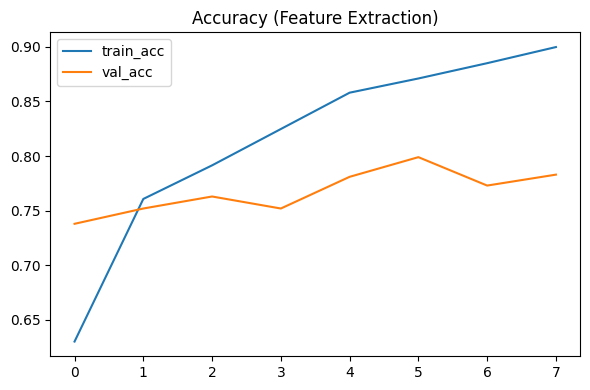

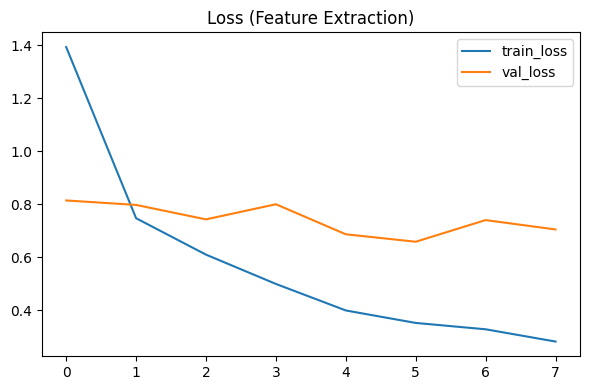

In [ ]:
# (정리됨) 위 e2e 학습 곡선은 사용하지 않습니다. 임베딩 기반 선형 분류 실험에서 필요시 새로 작성하세요.

## 5. 평가 + 혼동행렬

[TEST] Accuracy: 0.7853


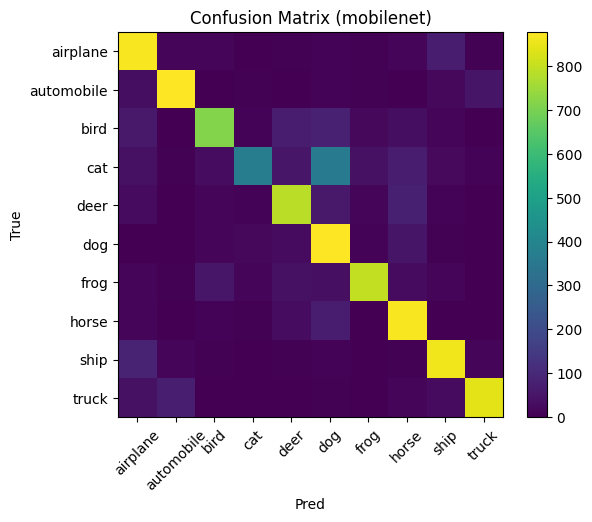


[Classification Report]
               precision    recall  f1-score   support

    airplane       0.74      0.87      0.80      1000
  automobile       0.88      0.88      0.88      1000
        bird       0.84      0.71      0.77      1000
         cat       0.85      0.37      0.51      1000
        deer       0.77      0.79      0.78      1000
         dog       0.58      0.88      0.70      1000
        frog       0.89      0.80      0.84      1000
       horse       0.75      0.87      0.81      1000
        ship       0.83      0.86      0.84      1000
       truck       0.91      0.84      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.78     10000
weighted avg       0.80      0.79      0.78     10000



In [ ]:
# (정리됨) e2e 모델 평가 대신, 아래 임베딩 기반 평가 셀을 사용하세요.

## 6.5 모델 성능 비교 (MobileNet vs EfficientNet)

- 동일한 설정(이미 변환/데이터/러닝레이트/에폭)에서 두 백본을 각각 학습
- 검증/테스트 정확도를 비교해 어떤 백본이 본 실습 환경에서 더 유리한지 확인


In [ ]:
# (정리됨) 비교 실험(e2e 학습)은 본 노트북 범위를 넘어 임베딩 기반 실험으로 대체합니다.


/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_8974/2491700475.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y=x.to(device),torch.tensor(y).to(device)
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_8974/2491700475.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y=x.to(device),torch.tensor(y).to(device)


[MN Ep 1/8] train=0.616/1.428  val=0.695/0.956
[MN Ep 2/8] train=0.741/0.782  val=0.744/0.832
[MN Ep 3/8] train=0.788/0.616  val=0.759/0.763
[MN Ep 4/8] train=0.830/0.488  val=0.733/0.903
[MN Ep 5/8] train=0.841/0.436  val=0.775/0.741
[MN Ep 6/8] train=0.871/0.370  val=0.788/0.687
[MN Ep 7/8] train=0.884/0.315  val=0.803/0.730
[MN Ep 8/8] train=0.895/0.287  val=0.783/0.773
[MN TEST] acc=0.7892


/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_8974/2491700475.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y=x.to(device),torch.tensor(y).to(device)
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_8974/2491700475.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y=x.to(device),torch.tensor(y).to(device)


[EF Ep 1/8] train=0.605/1.350  val=0.701/0.999
[EF Ep 2/8] train=0.802/0.586  val=0.726/0.894
[EF Ep 3/8] train=0.858/0.399  val=0.730/0.904
[EF Ep 4/8] train=0.906/0.276  val=0.735/0.856
[EF Ep 5/8] train=0.932/0.202  val=0.750/0.894
[EF Ep 6/8] train=0.944/0.173  val=0.744/0.899
[EF Ep 7/8] train=0.949/0.153  val=0.761/0.810
[EF Ep 8/8] train=0.963/0.117  val=0.762/0.879
[EF TEST] acc=0.7732

=== 비교 결과 ===
MobileNetV3-Small Test Acc: 0.7892
EfficientNet-B0     Test Acc: 0.7732


## 7. 성능 향상 방안 제안 및 적용

- 데이터 증강 강화(RandAugment, RandomErasing)
- Label Smoothing Loss
- 학습률 스케줄러(cosine)

아래는 위 3가지를 적용한 재학습 예시입니다.


In [ ]:
# (정리됨) 고급 증강/스케줄링 e2e 예시는 별도 노트북으로 분리 권장. 본 노트북은 간결 버전 유지.


/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_8974/1712934588.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y=x.to(device),torch.tensor(y).to(device)
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_8974/2491700475.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y=x.to(device),torch.tensor(y).to(device)


[Strong Ep 1/8] train=0.319 val=0.639
[Strong Ep 2/8] train=0.381 val=0.693
[Strong Ep 3/8] train=0.410 val=0.689
[Strong Ep 4/8] train=0.439 val=0.730
[Strong Ep 5/8] train=0.440 val=0.766
[Strong Ep 6/8] train=0.467 val=0.782
[Strong Ep 7/8] train=0.486 val=0.780
[Strong Ep 8/8] train=0.488 val=0.790
[Strong TEST] acc=0.7916


In [ ]:
# (정리됨) 고급 하이퍼파라미터 실험 셀은 본 노트북에서 제외합니다.

/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_8974/2999638166.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y=x.to(device),torch.tensor(y).to(device)
/Users/kimjinseok/Desktop/metacode-lecture/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_8974/2491700475.py:20: UserWar

[Strong Ep 1/8] train=0.312 val=0.607
[Strong Ep 2/8] train=0.407 val=0.683
[Strong Ep 3/8] train=0.463 val=0.692
[Strong Ep 4/8] train=0.482 val=0.722
[Strong Ep 5/8] train=0.509 val=0.756
[Strong Ep 6/8] train=0.534 val=0.785
[Strong Ep 7/8] train=0.550 val=0.774
[Strong Ep 8/8] train=0.554 val=0.789


In [67]:
# # 내부 구조 요약 유틸
# from collections import defaultdict

# def summarize_timm_model(model):
#     summary = []
#     for name, module in model.named_modules():
#         if name == '':
#             continue
#         cls = module.__class__.__name__
#         if any(k in cls.lower() for k in ['conv', 'batchnorm', 'bn', 'linear', 'se', 'activation', 'pool', 'mbconv', 'bottleneck', 'inverted', 'depthwise']):
#             summary.append((name, cls))
#     return summary

# # 두 모델을 각각 생성(헤드 num_classes=10으로 동일)
# mb_model = timm.create_model(f'hf_hub:{mobilenet_repo}', pretrained=True, num_classes=10)
# ef_model = timm.create_model(f'hf_hub:{efficient_repo}', pretrained=True, num_classes=10)

# mb_summary = summarize_timm_model(mb_model)
# ef_summary = summarize_timm_model(ef_model)

# print('MobileNet 주요 모듈(상위 25개):')
# for n,c in mb_summary[:25]:
#     print(f' - {n}: {c}')
# print('\nEfficientNet 주요 모듈(상위 25개):')
# for n,c in ef_summary[:25]:
#     print(f' - {n}: {c}')


## 8. 요약 및 가이드

- MobileNet/EfficientNet 내부 구조와 차이점(MBConv, SE, compound scaling)
- 동일 설정에서의 성능 비교: 데이터셋/Subset/에폭에 따라 변동 가능
- 간단한 기법만으로도 성능 향상(Label Smoothing, 강한 증강, Cosine)

실습 팁
- CPU 환경에서는 Feature Extraction 중심으로 빠르게 확인
- 시간이 더 있으면 에폭 수만 늘려도 성능이 개선될 수 있음


In [68]:

# import torch
# import torch.nn as nn
# from torchinfo import summary  # torchinfo가 없으면 torchsummary도 OK
# from torchvision.models import mobilenet_v2, efficientnet_b0

In [69]:

# # Depthwise Separable Conv: (Depthwise) + (Pointwise)
# class DepthwiseSeparableConv(nn.Module):
#     def __init__(self, in_ch, out_ch, k=3, s=1):
#         super().__init__()
#         self.depthwise = nn.Conv2d(in_ch, in_ch, k, s, k//2, groups=in_ch, bias=False)
#         self.pointwise = nn.Conv2d(in_ch, out_ch, 1, 1, 0, bias=False)
#         self.bn = nn.BatchNorm2d(out_ch)
#         self.act = nn.ReLU6(inplace=True)
#     def forward(self, x):
#         x = self.depthwise(x)
#         x = self.pointwise(x)
#         x = self.bn(x)
#         return self.act(x)

# # MobileNetV2: Inverted Residual + Linear Bottleneck
# class InvertedResidual(nn.Module):
#     def __init__(self, in_ch, out_ch, stride, expand_ratio):
#         super().__init__()
#         hidden_dim = int(round(in_ch * expand_ratio))
#         self.use_res_connect = (stride == 1 and in_ch == out_ch)

#         layers = []
#         if expand_ratio != 1:
#             layers += [nn.Conv2d(in_ch, hidden_dim, 1, bias=False),
#                        nn.BatchNorm2d(hidden_dim),
#                        nn.ReLU6(inplace=True)]
#         # depthwise
#         layers += [nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
#                    nn.BatchNorm2d(hidden_dim),
#                    nn.ReLU6(inplace=True)]
#         # pointwise-linear (linear bottleneck)
#         layers += [nn.Conv2d(hidden_dim, out_ch, 1, bias=False),
#                    nn.BatchNorm2d(out_ch)]
#         self.conv = nn.Sequential(*layers)

#     def forward(self, x):
#         out = self.conv(x)
#         return x + out if self.use_res_connect else out

# # Squeeze-and-Excitation (SE) for EfficientNet
# class SE(nn.Module):
#     def __init__(self, ch, r=4):
#         super().__init__()
#         self.fc = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(ch, ch // r, 1),
#             nn.SiLU(inplace=True),
#             nn.Conv2d(ch // r, ch, 1),
#             nn.Sigmoid()
#         )
#     def forward(self, x):
#         w = self.fc(x)
#         return x * w

# # EfficientNet 스타일의 MBConv (SiLU + SE 포함)
# class MBConv(nn.Module):
#     def __init__(self, in_ch, out_ch, stride=1, expand_ratio=4, k=3, se=True):
#         super().__init__()
#         hidden = in_ch * expand_ratio
#         self.use_res = (stride == 1 and in_ch == out_ch)

#         self.expand = nn.Sequential(
#             nn.Conv2d(in_ch, hidden, 1, bias=False),
#             nn.BatchNorm2d(hidden),
#             nn.SiLU(inplace=True),
#         ) if expand_ratio != 1 else nn.Identity()

#         self.dw = nn.Sequential(
#             nn.Conv2d(hidden if expand_ratio!=1 else in_ch,
#                       hidden if expand_ratio!=1 else in_ch,
#                       k, stride, k//2, groups=(hidden if expand_ratio!=1 else in_ch), bias=False),
#             nn.BatchNorm2d(hidden if expand_ratio!=1 else in_ch),
#             nn.SiLU(inplace=True),
#         )

#         ch_mid = hidden if expand_ratio!=1 else in_ch
#         self.se = SE(ch_mid) if se else nn.Identity()

#         self.pw = nn.Sequential(
#             nn.Conv2d(ch_mid, out_ch, 1, bias=False),
#             nn.BatchNorm2d(out_ch)
#         )

#     def forward(self, x):
#         identity = x
#         x = self.expand(x)
#         x = self.dw(x)
#         x = self.se(x)
#         x = self.pw(x)
#         return x + identity if self.use_res else x


In [70]:

# dummy = torch.randn(1, 16, 56, 56)

# print("=== Depthwise Separable Conv 예시 ===")
# m = DepthwiseSeparableConv(16, 24, k=3, s=2)
# print(m)
# out = m(dummy)
# print("Output shape:", out.shape)

# print("\n=== MobileNetV2 InvertedResidual 예시 ===")
# ir = InvertedResidual(16, 24, stride=2, expand_ratio=6)
# print(ir)
# out = ir(dummy)
# print("Output shape:", out.shape)

# print("\n=== EfficientNet MBConv 예시 ===")
# mb = MBConv(16, 24, stride=2, expand_ratio=4, k=3, se=True)
# print(mb)
# out = mb(dummy)
# print("Output shape:", out.shape)


In [71]:
# mobilenet = mobilenet_v2(weights=None)
# efficient = efficientnet_b0(weights=None)

# print("=== MobileNetV2 summary ===")
# summary(mobilenet, input_size=(1, 3, 224, 224))




In [72]:

# print("\n=== EfficientNet-B0 summary ===")
# summary(efficient, input_size=(1, 3, 224, 224))


In [73]:

# shapes = []
# def hook(module, inp, out):
#     if isinstance(out, torch.Tensor):
#         shapes.append((module.__class__.__name__, tuple(out.shape)))

# handles = []
# for name, module in mobilenet.features._modules.items():
#     handles.append(module.register_forward_hook(hook))

# _ = mobilenet(torch.randn(1,3,224,224))
# for h in handles: h.remove()

# print("=== MobileNetV2 feature map flow ===")
# for n, s in shapes[:10]:  # 앞쪽 10개만 예시 출력
#     print(f"{n:28s} -> {s}")


In [74]:
# import os, subprocess

# cands = []
# try:
#     prefix = subprocess.getoutput("brew --prefix graphviz").strip()
#     if prefix and prefix != "": cands.append(f"{prefix}/bin/dot")
# except Exception:
#     pass
# cands += [
#     "/opt/homebrew/opt/graphviz/bin/dot",  # Apple Silicon brew prefix
#     "/usr/local/opt/graphviz/bin/dot",     # Intel brew prefix
#     "/opt/homebrew/bin/dot",
#     "/usr/local/bin/dot",
# ]

# found = None
# for p in cands:
#     if os.path.exists(p):
#         found = p
#         break

# if found:
#     os.environ["GRAPHVIZ_DOT"] = found
#     # PATH에도 추가(선택)
#     os.environ["PATH"] += os.pathsep + os.path.dirname(found)
#     print("GRAPHVIZ_DOT =", os.environ["GRAPHVIZ_DOT"])
# else:
#     print("dot 실행파일을 찾지 못했습니다. 터미널에서 다음을 실행하세요:")
#     print("  brew reinstall graphviz")
#     print("  brew link graphviz --force")

In [75]:
print(shutil.which("dot"))

/usr/local/bin/dot


In [76]:
# # 그래프 렌더링 시도 → 실패 시 요약으로 대체
# try:
#     from torchviz import make_dot
#     x = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
#     model.eval()
#     y = model(x)
#     dot = make_dot(y, params=dict(list(model.named_parameters())))
#     dot.format = "png"
#     dot.render("model_graph")  # ./model_graph.png 생성
#     print("Graphviz 렌더링 완료")
# except Exception as e:
#     print("Graphviz 렌더링 생략:", e)
#     from torchinfo import summary
#     summary(model, input_size=(1, 3, IMG_SIZE, IMG_SIZE),
#             depth=3, col_names=("input_size","output_size","num_params","kernel_size"))

In [77]:
# from torchinfo import summary

# # 현재 사용 중인 모델 구조 요약
# summary(model, input_size=(1, 3, IMG_SIZE, IMG_SIZE),
#         depth=3, col_names=("input_size","output_size","num_params","kernel_size"))

In [78]:
# from torchinfo import summary
# mn = timm.create_model(f'hf_hub:{mobilenet_repo}', pretrained=True, num_classes=10).to(device)
# ef = timm.create_model(f'hf_hub:{efficient_repo}', pretrained=True, num_classes=10).to(device)

# summary(mn, input_size=(1,3,IMG_SIZE,IMG_SIZE), depth=3)
# summary(ef, input_size=(1,3,IMG_SIZE,IMG_SIZE), depth=3)

In [79]:

# from torchviz import make_dot
# x = torch.randn(1,3,224,224)
# y = mobilenet(x)
# dot = make_dot(y, params=dict(list(mobilenet.named_parameters())))
# dot.format = 'png'
# dot.render('mobilenet_v2_graph')  # ./mobilenet_v2_graph.png


In [80]:
# # 내부 구조 요약 유틸
# from collections import defaultdict

# def summarize_timm_model(model):
#     summary = []
#     for name, module in model.named_modules():
#         if name == '':
#             continue
#         cls = module.__class__.__name__
#         if any(k in cls.lower() for k in ['conv', 'batchnorm', 'bn', 'linear', 'se', 'activation', 'pool', 'mbconv', 'bottleneck', 'inverted', 'depthwise']):
#             summary.append((name, cls))
#     return summary

# # 두 모델을 각각 생성(헤드 num_classes=10으로 동일)
# mb_model = timm.create_model(f'hf_hub:{mobilenet_repo}', pretrained=True, num_classes=10)
# ef_model = timm.create_model(f'hf_hub:{efficient_repo}', pretrained=True, num_classes=10)

# mb_summary = summarize_timm_model(mb_model)
# ef_summary = summarize_timm_model(ef_model)

# print('MobileNet 주요 모듈(상위 25개):')
# for n,c in mb_summary[:25]:
#     print(f' - {n}: {c}')
# print('\nEfficientNet 주요 모듈(상위 25개):')
# for n,c in ef_summary[:25]:
#     print(f' - {n}: {c}')


In [81]:
# # 내부 구조 요약 유틸
# from collections import defaultdict

# def summarize_timm_model(model):
#     summary = []
#     for name, module in model.named_modules():
#         if name == '':
#             continue
#         cls = module.__class__.__name__
#         if any(k in cls.lower() for k in ['conv', 'batchnorm', 'bn', 'linear', 'se', 'activation', 'pool', 'mbconv', 'bottleneck', 'inverted', 'depthwise']):
#             summary.append((name, cls))
#     return summary

# # 두 모델을 각각 생성(헤드 num_classes=10으로 동일)
# mb_model = timm.create_model(f'hf_hub:{mobilenet_repo}', pretrained=True, num_classes=10)
# ef_model = timm.create_model(f'hf_hub:{efficient_repo}', pretrained=True, num_classes=10)

# mb_summary = summarize_timm_model(mb_model)
# ef_summary = summarize_timm_model(ef_model)

# print('MobileNet 주요 모듈(상위 25개):')
# for n,c in mb_summary[:25]:
#     print(f' - {n}: {c}')
# print('\nEfficientNet 주요 모듈(상위 25개):')
# for n,c in ef_summary[:25]:
#     print(f' - {n}: {c}')
